In [1]:
!pip install numpy matplotlib scipy --user

You are using pip version 19.0, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage.filters import gaussian_filter

In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

# Edge Detection

What are edges? Edges are areas in the image which have large discontinuities in their intensity values. <br>
In order to detect edges, we will use a naive approach based on image gradients. <br>

The idea is pretty simple and intuitive. For vertical edges, we will have large gradients along x axis and similarly, for horizontal edges, we will have large gradients along y axis. We will compute gradients along x and y axes and compute the magnitude as described below. This will give us the intensity of the gradient at that pixel.

To summarize, you have to

- Read an image using opencv. (See cv2.imread())
- Convert it into grayscale.  (Use rgb2gray() or cv2.cvtColor())
- Compute gradients in x and y direction, i.e, compute $I_x$ and $I_y$ 
- The gradient along x-direction is given by $ I_x(i, j) = I(i, j+1) - I(i, j) $, where $I(i, j)$ represents intensity of the image at pixel $(i, j)$.
- Similarly, the gradient along y-direction is given by $ I_y(i, j) = I(i+1, j) - I(i, j) $
- Create a new image which has intensity values as $ I(i, j) = \sqrt{{I_x(i, j)}^2 + {I_y(i, j)}^2} $
- Display this image

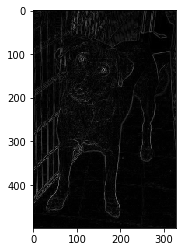

In [4]:
import math

filename = 'dog.1.jpg'
img = cv2.imread(filename)
gray = rgb2gray(img).astype(np.float32)
def detect_edges(gray):
    for i in range(0, len(gray) - 1):
        for j in range(0, len(gray[0]) - 1):
            x_intensity = gray[i][j + 1] - gray[i][j]
            y_intensity = gray[i+1][j] - gray[i][j]
            gray[i][j] = math.sqrt(x_intensity**2 + y_intensity**2)
    return gray
            
plt.imshow(detect_edges(gray), cmap='gray')
plt.show()

# Corner Detectors

Now we will use another naive approach to detect corners in an image. These corners can help identify a lot of interesting keypoints in an image, and are extensively used in panorama stitching, 3D reconstruction, optical flow (motion estimation) and various other downstream tasks.

The best way to characterize corners in an image would be to look at windows (or kernels) of some size (say 3x3) and see how much the intensity values vary when we move the window in any direction. If there is a large change in intensity value when we move the window in only one direction, we can say that there might be an edge present there. However, if the intensity change is big for both directions, we can say there might be a corner present in the image.

![Corners](corners1.png)

This is precisely the approach we will follow. <br>

Since the images can have sharp discontinuities at many other pixel locations which are not corners, we will use a gaussial kernel to 'smooth' the image. This simple means making a call to scipy.misc.gaussian_filter(image, standard_deviation) before doing any operations on the image. This will help us reject a lot of misclassified corners.

We will use a sliding window of size *windowSize* and slide it across the image. For every window that we see in this image, we will compute a moment matrix as follows.

$$
M(i, j) = \quad \begin{bmatrix} \sum I_x^2 & \sum I_{x} I_y \\ \sum I_x I_y & \sum I_y^2 \end{bmatrix}
$$
Where $I_x$ is the image gradient along x direction, $I_y$ is the image gradient along y direction, and this sume is across a window of size (k x k). 

![Convolution](convolutions.gif)


Hence for every pixel $(i, j)$ we use a window that spans across $(i - k/2, j - k/2)$ to $(i+k/2, j+k/2)$ and create the Moment matrix. This moment matrix is simply a 2x2 matrix. Now, whether or not there exists a corner at pixel (i, j) is found my computing the eigenvalues of M(i, j). You can use np.linalg.eigvals(x) to compute eigenvalues of a matrix x. We will have an edge if only one of the eigenvalue is large. If both these eigenvalues are large, we have a corner, and those are the points we're interested in.

Your task is to implement the detect_corners() method below which takes in a grayscale image, the maximum number of corners to return, standard deviation of the gaussian kernel and the size of the sliding window and does the following
- filters the image using a gaussian kernel of standard deviation = smoothSTD  (scipy.misc.gaussian_filter())
- computes the image gradients along x and y directions   (you can use np.gradient())
- for each window in the smoothed image, computes the Moment Matrix M and it's eigenvalues. If both the eigenvalues are large, we add this pixel to the list of corners.
- Returns the top n = max_num_of_corners from this list.

You can read more about this here: https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html

In [5]:
def detect_corners(image, max_num_of_corners, smoothSTD, windowSize):
    """
    Detect corners on a given image.

    Args:
        image: Given a grayscale image on which to detect corners.
        max_num_of_corners: Total number of corners to be extracted.
        smoothSTD: Standard deviation of the Gaussian smoothing kernel.
        windowSize: Window size for corner detector and non maximum suppression.

    Returns:
        Detected corners (in image coordinate, i.e, x and y coordinate of the pixels 
        corresponding to corners) in a numpy array (n*2).

    """
    
    """
    Your code here:
    """
    
    filtered_image = gaussian_filter(image, smoothSTD)
    grad_y, grad_x = np.gradient(filtered_image)
    
    
    corners = []
    k = (windowSize-1)//2
    
    count = 0
    large = 150
    for i in range(k, filtered_image.shape[0] - k, windowSize):
        for j in range(k, filtered_image.shape[1] - k, windowSize):
            
            x_sum = 0
            y_sum = 0
            xy_sum = 0
            for i_sub in range(i-k, i+k+1):
                for j_sub in range(j-k, j+k+1):
                    x_sum += grad_x[i_sub][j_sub]**2
                    y_sum += grad_y[i_sub][j_sub]**2
                    xy_sum += grad_x[i_sub][j_sub]*grad_y[i_sub][j_sub]
            M = [[x_sum,xy_sum],[xy_sum, y_sum]]
            
            eig1, eig2 = np.linalg.eigvals(M) 
            if min(eig1, eig2) > large:
                corners.append({"coords":(j,i), "eigs":(eig1, eig2)})
            
            #Compute it's eigenvalues and see if (i, j) is a corner. Hint: check if min(eig1, eig2) is large.
    
    # NOTE: We chose to sort the detected corners to improve the appearance of the corner detection
    corners = sorted(corners, key=functools.cmp_to_key(compare))
    result=[[x["coords"][0], x["coords"][1]] for x in corners]
    #print(result)
    return np.asarray(result[:max_num_of_corners])
    # Return top max_num_of_corners from list of corners. Hint: sort them using their smallest eigenvalue.

In [6]:
import functools
def compare(a, b):
    if min(a["eigs"]) > min(b["eigs"]):
        return -1
    elif min(a["eigs"]) < min(b["eigs"]):
        return 1
    return 0

In [7]:
nCorners = 40        # Maximum number of corners to return
smoothSTD = 2        # Smooth image with a gaussian filter of this standard deviation
windowSize = 5       # Window size for the sliding kernel

# read images and detect corners on images
imgs_dogs = []
crns_dogs = []
imgs_cats = []
crns_cats = []

for i in range(2):
    img_1 = cv2.imread('dog.' + str(i) + '.jpg')
    imgs_dogs.append(rgb2gray(img_1))
    crns_dogs.append(detect_corners(imgs_dogs[i], nCorners, smoothSTD, windowSize))
    
    img_2 = cv2.imread('cat.' + str(i) + '.jpg')
    imgs_cats.append(rgb2gray(img_2))
    crns_cats.append(detect_corners(imgs_cats[i], nCorners, smoothSTD, windowSize))

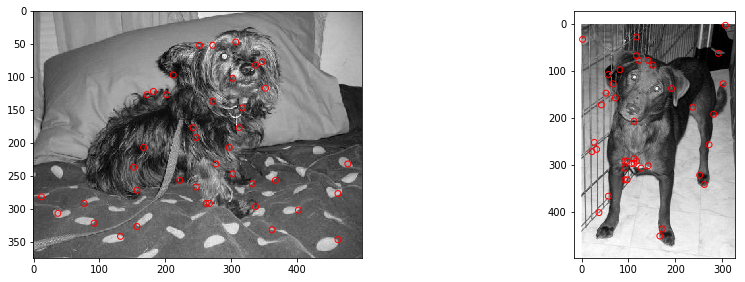

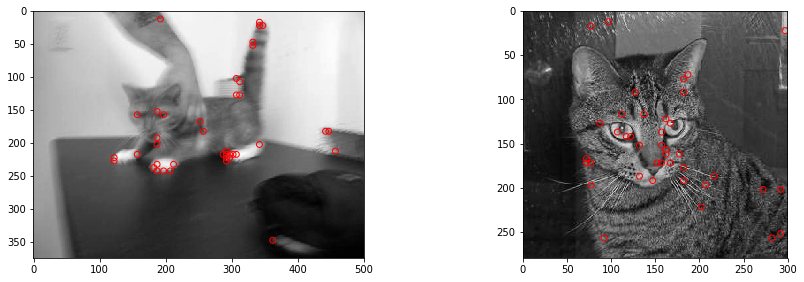

In [8]:
def plot_corners(imgs, corners):
    fig = plt.figure(figsize=(15, 10))
    ax1 = fig.add_subplot(221)
    ax1.imshow(imgs[0], cmap='gray')
    #print(corners)
    ax1.scatter(corners[0][:, 0], corners[0][:, 1], s=35, edgecolors='r', facecolors='none')

    ax2 = fig.add_subplot(222)
    ax2.imshow(imgs[1], cmap='gray')
    ax2.scatter(corners[1][:, 0], corners[1][:, 1], s=35, edgecolors='r', facecolors='none')
    plt.show()

plot_corners(imgs_dogs, crns_dogs)
plot_corners(imgs_cats, crns_cats)